# **Mount Your Drive Down**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **SHORTENING TALKS**

**Shortening Talks Algorithm**
* **Method 1 (TF-IDF)**: 
    * *Layer 1 : KeyWord Extraction using log(1+ Frequency) x log(Lines In Total/Lines Containing word) (TFIDF) Scores*
    * *Layer 2 : KeyWord Allotment to Sentences using Lev Ratios*
*  **Method 2 (Frequency)**:
    * *Layer 1 : KeyWord Extraction  using Frequency Scores*
    * *Layer 2 : KeyWord Allotment to Sentences using Lev Ratios*  

* **Method 3 (BERT Embedding + BERT Classifier)**:
  *  *Layer 1 : Sequence the words in a sentence and pass into BERT*
  *  *Layer 2 : Top BERT Classifier to produce important/unimportant sentences*

*  **Method 4 (BERT Embedding + LexRank)**:
  *  *Layer1 : Sentense to BERT Embeddings*
     *Layer 2 : LexRank on sentence vecs and pick sentence vecs above set threshold rank* 

In [ ]:
pip install fuzzywuzzy

In [ ]:
pip install wikipedia


  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp37-none-any.whl size=11686 sha256=022897f7e84bfa769b5e7926bf9d3e8826029bb2965ea7f26de1f769fd8ad65e
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia


In [ ]:
import wikipedia
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import copy
import numpy as np
import json
import copy
import nltk
import numpy as np
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from scipy import stats
from math import *
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('wordnet')
nltk.download('stopwords')


T1path = "/content/drive/My Drive/AppleTranscript1.txt" #"/content/drive/My Drive/transcript1"
T2path = "/content/drive/My Drive/AppleTranscript2.txt" #"/content/drive/My Drive/transcript2"
T3path = "/content/drive/My Drive/AppleTranscript3.txt" #"/content/drive/My Drive/transcript3"
T4path = "/content/drive/My Drive/AppleTranscript4.txt" #"/content/drive/My Drive/transcript4"
Tpath = "/content/drive/My Drive/entireAppleTranscript.txt" #"/content/drive/My Drive/entireTranscript.txt"

transcript = "" 
tpt1 = open(T1path,"r")
T1 = tpt1.read()
T1dict = eval(T1)
tpt1.close()

tpt2 = open(T2path,"r")
T2 = tpt2.read()
T2dict = eval(T2)
tpt2.close()

tpt3 = open(T3path,"r")
T3 = tpt3.read()
T3dict = eval(T3)
#T3dict = json.loads(T3dict.decode("utf-8"))
tpt3.close()

tpt4 = open(T4path,"r")
T4 = tpt4.read()
T4dict = eval(T4)
#T4dict = json.loads(T4dict.decode("utf-8"))
tpt4.close()

transcript += T1dict["response"]["transcript"]
transcript += T2dict["response"]["transcript"]
transcript += T3dict["response"]["transcript"]
transcript += T4dict["response"]["transcript"]

tpt = open(Tpath,"w")
tpt.write(transcript)
tpt.close()

#tpt  = open(Tpath,"r")
Tdicts = [T1dict,T2dict,T3dict,T4dict]
#print(tpt.read())       
        
#RUN THIS CELL WITH SPECIFIED PATH TO LOAD ALL THE TEXT FILE AS STRING INTO "wholeText" AND TEXT FILE AS LINES INTO "lineWiseText"

#path = "/content/drive/My Drive/TedTranscript.txt" #Path of the file from the drive
path = Tpath # "/content/drive/My Drive/entireTranscript.txt"

chunk(path,endLineAt=[".","?"])               

fi = open(path,"r")
wholeText = fi.read()
fi.seek(0)
totalWords = len((fi.read()).split())
fi.seek(0)
totalLines = len(fi.readlines())
fi.seek(0)
lineWiseText = fi.readlines()
fi.close()

#print("Total Lines present in the Source File is : ", totalLines)
#print("Total Words present in the source File is : ", totalWords)

def superImportant(topic) :

  content = wikipedia.summary(topic)
  pageObj = wikipedia.WikipediaPage(topic)

  hyperLinks1 = []
  nonhyperLinks = content.split()
  for words2 in pageObj.links:
    if words2 in content:
      hyperLinks1.append(words2)

  contentWords = list(set(copy.deepcopy(hyperLinks1) + nonhyperLinks))
  
  fails = 0

  for words in hyperLinks1:
    try :
      content = wikipedia.summary(words)
      pageObj = wikipedia.WikipediaPage(words)
      count =0
      for words2 in pageObj.links:
        if words2 in content:
        
          contentWords.append(words2)
          count+=1
        if count >= 1*len(hyperLinks1):
          break
    except :
      fails +=1
  
  contentWords = set((" ".join(contentWords)).split())
  return contentWords

def changePriorities(dic, mapWords):
  frequencies = []
  for k,v in dic.items():
    frequencies.append(v)
  X = copy.deepcopy(np.percentile(np.array(frequencies),95))
  
  misMatches = 0
  for words in mapWords:
    if words in dic.keys():
      dic[words] = X
    elif words.lower() in dic.keys():
      dic[words.lower()] = X
    else:
      misMatches +=1

  return dic, misMatches
#JUST RUN THIS CELL


def chunk(sourceFile, wordsPerLine = None, endLineAt = None ):
  fi = open(sourceFile,"r+")
  text = fi.read()
  text = text.replace("\n","")

  

  if wordsPerLine != None :
   text = text.split()
   for words in range(1,len(text)+1):
      if words%3 == 0:
        text[words-1] = text[words-1] + "\n" 
   fi.seek(0)
   fi.write(" ".join(text))
  if endLineAt != None :
    
    for words in endLineAt :
      text = text.split(words)
      text = "\n".join(text)
      

    fi.seek(0)
    fi.write(text)
  
  fi.close()
  return

def getKey(D,val): 
    for key, value in D.items(): 
         if val == value: 
             return key 
    return -1

def inNLines(multiLineTxt, word, limitOnDataL = totalLines):
  count = 0
  multiLineTxt = [sen.lower() for sen in multiLineTxt] 
  options = process.extract(word,multiLineTxt,limit = limitOnDataL)
  
  for line,score in options:
    thresholdMatchScore = (len(word)/len(line))*100
    if (score >=thresholdMatchScore and len(word) >= 3) or (word in line.split()) :
      count += 1
  return count

def completeFiltering(singleStringTxt, multiLineTxt, limitOnFreq, limitOnDataW = 10000):
  wholeText = singleStringTxt
  cleansed = wholeText.split()[:limitOnDataW]
  table = str.maketrans("","",string.punctuation)
  cleansed = [w.translate(table) for w in cleansed]
  patched = " ".join(cleansed)
  cleansed = patched.split()
  cleansed = [words for words in cleansed if not words.lower() in stopwords.words()]
  
  cleansedTxt = " ".join(cleansed)

  wholeText = [cleansedTxt]
  lineWiseText = multiLineTxt

  # list of text documents
  # create the transform
  vectorizer1 = CountVectorizer()
  vectorizer2 = CountVectorizer()
  # tokenize and build vocab
  vectorizer1.fit(wholeText)
  vectorizer2.fit(lineWiseText)

  # summarize
  wToInd1 = vectorizer1.vocabulary_
  wToInd2 = vectorizer2.vocabulary_
  # encode document
  vector1 = vectorizer1.transform(wholeText)
  vector2 = vectorizer2.transform(lineWiseText)
  # summarize encoded vector
  v1 = vector1.toarray()
  v2 = vector2.toarray()
  
  
  finalCount = np.sum(v1,axis = 0,keepdims = False)
  
  countDict1 = dict()
  
  countDict2 = dict()
  countDict3 = dict()
  priorities2 = dict()

  for ind in range(len(finalCount)):
    if finalCount[ind] >=limitOnFreq :
      countDict1[getKey(wToInd1,ind)] = finalCount[ind]
      countDict3[getKey(wToInd1,ind)] = inNLines(multiLineTxt, getKey(wToInd1,ind))
  
  for lines in range(v2.shape[0]):
    countDict = dict()
    for ind in range(v2.shape[1]):
      if v2[lines][ind] >=limitOnFreq :
        countDict[getKey(wToInd2,ind)] = v2[lines][ind]
        
    
    priorities = sorted(countDict,key=countDict.get,reverse=True)
    
    countDict2[str(lines+1)] = countDict
    priorities2[str(lines+1)] = priorities

  contentWords = superImportant("Apple Inc")
  countDict1, misMatch = changePriorities(countDict1, contentWords)
  print("These many got mismatched : ", misMatch)
  
  priorities1 = sorted(countDict1,key=countDict1.get,reverse=True)
  priorities3 = sorted(countDict3, key = countDict3.get, reverse = True)
  
  
  
  return priorities1, priorities2, priorities3, countDict1, countDict2, countDict3

def fuzzyWayCondense(fileSource, priorities1, priorities2, prioritiesMap1, prioritiesMap2, limitOnLines = 3, limitOnDataL = 100, method = "Frequency", printLineScores = False):
  
  if method == "Frequency":
    priorities = priorities1
    prioritiesMap = prioritiesMap1
  elif method == "TF-IDF":
    priorities = priorities1
    prioritiesMap = prioritiesMap1
    prioritiesMapext = prioritiesMap2
    includeTFIDF = np.zeros((limitOnDataL,len(priorities)))

  fi = open(fileSource,"r")
  include = np.zeros((limitOnDataL,len(priorities)))
  
  wholeLines = fi.readlines()[:limitOnDataL]
  maintain = dict()
  
  for lines in range(1,limitOnDataL +1):
    maintain[str(lines)] = []
  
  fi.close()
  
  for words in priorities:
    options = process.extract(words,wholeLines,limit = limitOnDataL)
    for line,score in options:
      thresholdMatchScore = (len(words)/len(line))*100
      if ( words in line.split() or (score >=thresholdMatchScore and len(words)>=3) ) and method == "Frequency":
        maintain[str(wholeLines.index(line)+1)].append(words)
        include[wholeLines.index(line)][priorities.index(words)] = 1*prioritiesMap[words]
      elif ( words in line.split() or (score>=thresholdMatchScore and len(words)>=3) ) and method == "TF-IDF":

        maintain[str(wholeLines.index(line)+1)].append(words)
        #includeTFIDF[wholeLines.index(line)][priorities.index(words)] = prioritiesMapext[str(wholeLines.index(line)+1)][words]*prioritiesMap[words]
        include[wholeLines.index(line)][priorities.index(words)] = log(limitOnDataL/prioritiesMapext[words])*log(1+prioritiesMap[words])*1
  
  """ if method == "TF-IDF":
    
    includeTFIDF = list(np.sum(includeTFIDF,axis=0))
    
    for words in priorities:
      options = process.extract(words,wholeLines,limit = limitOnDataL)
      for line,score in options:
      
        if (words in line.split()) :
          
          include[wholeLines.index(line)][priorities.index(words)] = score*includeTFIDF[priorities.index(words)]"""

  for lines in range(1,limitOnDataL +1):
     maintain[str(lines)] = set(maintain[str(lines)] )

  include = list(np.sum(include,axis =1))
  includeTemp = np.array(copy.deepcopy(include))
  
  if printLineScores == True :
    print("\nThe Scores of the Sentences from 1 to", limitOnDataL," are as follows \n", include)
    print("\nThe Key Words Per Line for all the lines are : \n", maintain)
 
  
  
  condensedLines = []
  condensedLinesIndices = []
  if limitOnLines != "NormSTDPick" :
    includeTemp = (np.sort(includeTemp))[::-1]
    for i in range(limitOnLines) :
      condensedLines.append(wholeLines[include.index(includeTemp[i])])
      condensedLinesIndices.append(include.index(includeTemp[i]) + 1)
      include[include.index(includeTemp[i])] = -1
  else :
    includeTemp = np.array([(value >= np.percentile(includeTemp, 50))for value in includeTemp]).astype(int)
    includeTemp = np.reshape(np.argwhere(includeTemp), (-1,)) + 1
    condensedLines = [wholeLines[i-1] for i in includeTemp]
    condensedLinesIndices = includeTemp

  condensedText = " ".join(condensedLines)

  return condensedText, condensedLines, condensedLinesIndices



# "completeFiltering" func takes "wholeText", "lineWiseText", "limitOnFreq" (let this be unchanged), "limitOnDataW" (this equals the "totalWords" in above cell)
# "completeFiltering" func returns priorities1,2 and countDict1,2 which are used more for internal purposes so I'm hiding these outputs
priorities1, priorities2, priorities3, countDict1, countDict2, countDict3 = completeFiltering(wholeText, lineWiseText,limitOnFreq = 1, limitOnDataW=totalWords)

#print("\nTop Prior Words of 10K Words data : ", priorities1)
#print("\nTop Prior Words of every Line data : ", priorities2)

# "fuzzyWayCondense" func takes "path", "priorities1,2", "countDict1,2", "limitOnLines" (this is can be anything <= "totalLines"), "limitonDataL"(this equals the "totalLines" in above cell), "method" (let it be unchanged), "printLineScores"(let it be False setting it to True just prints scores which are of no use to u)
# "fuzzyWayCondense" func returns "condensedText"(optional use to u), "condensedLines"(optional use to u just gives list of line strings) ,"condensedLinesIndices1(u might need this)"
condensedText, condensedLines, condensedLinesIndices1 = fuzzyWayCondense(path,priorities1, priorities3,countDict1, countDict3, limitOnLines="NormSTDPick", limitOnDataL = totalLines, method = "TF-IDF", printLineScores=False)
print("\nThis is the TF-IDF Way : \n")
print("\nThe Original Lines which made thorugh the filtering process  are the line numbers : \n", condensedLinesIndices1)
#print("\nOverall the condensed Text : \n", condensedText)

# "fuzzyWayCondense" func takes "path", "priorities1,2", "countDict1,2", "limitOnLines" (this is can be anything <= "totalLines"), "limitonDataL"(this equals the "totalLines" in above cell), "method" (let it be unchanged), "printLineScores"(let it be False setting it to True just prints scores which are of no use to u)
# "fuzzyWayCondense" func returns "condensedText"(optional use to u), "condensedLines"(optional use to u just gives list of line strings) ,"condensedLinesIndices2(u might need this)"
#condensedText, condensedLines, condensedLinesIndices2 = fuzzyWayCondense(path,priorities1, priorities2,countDict1, countDict2, limitOnLines="NormSTDPick", limitOnDataL = totalLines, method = "Frequency", printLineScores=False)
#print("\nThis is the Frequency Way : \n")
#print("\nThe Original Lines which made thorugh the filtering process  are the line numbers : \n", condensedLinesIndices2)
#print("\nOverall the condensed Text : \n", condensedText)

# "finalSet" gives union of results of both methods
#finalSet =  set(condensedLinesIndices1).union(set(condensedLinesIndices2))
finalSet =  set(condensedLinesIndices1)
print("\nConsider these lines as Important : ", finalSet )
print("\nPercentage of Condensation of initial Text is : {:.4f}%".format(((totalLines - len(finalSet))/totalLines)*100))


Jsonpath = "/content/drive/My Drive/entireAppleJason.txt" #"/content/drive/My Drive/entireJasonObj.txt"

correction = 0
for transcripts in range(4):
    for times in Tdicts[transcripts]["response"]["words"]:

      times["start"] = times["start"] + correction
      times["end"] = times["end"] + correction
      mark = times["end"]
      
    correction =   mark

jsonObjs = {"response" : dict()}
jsonObjs["response"]["words"] = T1dict["response"]["words"] + T2dict["response"]["words"] + T3dict["response"]["words"] + T4dict["response"]["words"]
jsonObjs = str(jsonObjs)
json = open(Jsonpath,"w")
json.write(jsonObjs)
json.close()


pathr = Jsonpath #"/content/drive/My Drive/tedxtJasonObject" # PATH TO THE TEXT FILE CONTAINING JASON OBJECT (DICTIONARY OF REQUEST ID, RESPONSE, TIMESTAMPS OF WORDS ....)
fi = open(pathr,"r")
fullDataDict = eval(fi.read())
def convert(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds) 

wholeWords = wholeText.split()
wholeLines = lineWiseText
prevWordsCount = dict()
wds = 0
for sen in wholeLines:
     prevWordsCount[str(wholeLines.index(sen)+1)] = wds
     wds += len(sen.split())


timeStamps = dict()

for line in finalSet:
     
     try:
      startInd = prevWordsCount[str(line)]
      endInd = prevWordsCount[str(line+1)] -1
     # USE "convert" if u need the output time stamps to be in HH:MM:SS if not remove "convert"
      timeRange = (fullDataDict["response"]["words"][startInd]["start"], fullDataDict["response"]["words"][endInd]["end"])
      timeStamps[int(line)] = timeRange
      count =1
     except :
      print("")

c = 0
Stamps = []
for line in sorted(timeStamps):
  c+=1
  Stamps.append(timeStamps[line])
print(Stamps)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


These many got mismatched :  492

This is the TF-IDF Way : 


The Original Lines which made thorugh the filtering process  are the line numbers : 
 [  5   6   8  10  12  13  14  15  17  21  22  24  25  28  29  31  32  35
  36  39  41  42  43  44  45  47  49  53  54  55  60  62  64  67  70  71
  73  75  76  79  85  87  88  90  92  93  94  95  97 100 106 108 110 111
 112 113 115 116 120 122 123 124 129 130 131 134 135 136 137 139 143 146
 148 149 150 151 154 157 159 160 161 162 163 165 168 170 174 176 178 179
 181 183 184 185 189 191 192 193 194 195 197 199 201 202 203 204 206 208
 210 215 216 217 219 220 221 222 223 224 225 228 229 230 232 235 238 239
 240 241 242 243 244 245 246 247 249 251 252 258 260 261 263 267 268 270
 272 273]

Consider these lines as Important :  {5, 6, 8, 10, 12, 13, 14, 15, 17, 21, 22, 24, 25, 28, 29, 31, 32, 35, 36, 39, 41, 42, 43, 44, 45, 47, 49, 53, 54, 55, 60, 62, 64, 67, 70, 71, 73, 75, 76, 79, 85, 87, 88, 90, 92, 93, 94, 95, 97, 100, 106, 108, 110, 111, 1

## **BERT Input Encoding And Model Creation And Execution**

In [ ]:
sample_transcript = """0:00a vector is something that has both
0:02magnitude and direction magnitude and
0:08direction so let's think of an example
0:10of what wouldn't and what would be a
0:13vector so if someone tells you that
0:15something is moving at five miles per
0:17hour this information by itself is not a
0:20vector quantity it's only it's only
0:23specifying a magnitude it's not we don't
0:26know what direction this thing is moving
0:27five miles per hour in so this right
0:30over here which is often referred to as
0:32a speed this is a speed is not a vector
0:36quantity just by itself this is
0:38considered to be a scalar quantity if we
0:41want it to be a vector we would also
0:43have to specify the direction so for
0:46example someone might say it's moving
0:48five miles per hour east let's say it's
0:51moving five miles per hour due east so
0:54now this combined five miles per hour
0:56are due east this is a vector quantity
0:58and now we wouldn't call it speed
1:00anymore we would call it velocity so
1:04velocity is a vector we're specifying
1:07the magnitude five miles per hour and
1:09the direction east but how would can we
1:13actually visualize this so let's say
1:15we're operating in two dimensions and
1:18what's neat about linear algebra is
1:19obviously a lot of what applies in two
1:21dimensions will extend to three and then
1:23even four or five six as many dimensions
1:25as we want our brains have trouble
1:27visualizing beyond three but what's neat
1:29is we can mathematically deal with
1:31beyond three using linear algebra and
1:33we'll see that in future videos but
1:35let's just go back to our straight
1:37traditional two-dimensional vector right
1:40over here so one way we could represent
1:42it as an arrow that is five units long
1:45we'll assume that each of our units are
1:47our unit here is miles per hour and
1:49that's pointed to the right where we'll
1:52say the right is east so for example I
1:55could start an arrow right over here and
1:57I could make its length five the length
2:00of the arrow specifies the magnitude so
2:03one two three four five and then the
2:08direction that the arrow is pointed in
2:10specifies its direction
2:13so this right over here could could
2:16represent visually this vector if we say
2:19that the horizontal axis is say East or
2:21the positive horizontal Direction is
2:23moving in the east this would be West
2:25that would be north and then that would
2:27be south now it's interesting about
2:29vectors is that we only care about the
2:31magnitude in the direction we don't
2:32necessarily not care where we start
2:35where we place it when we think about it
2:37visually like this so for example this
2:39would be the exact same vector would be
2:41equivalent vector to this this vector
2:44has the same length so it has the same
2:46magnitude has a length of five and its
2:49direction is also due east so these two
2:51vectors are equivalent now one thing
2:54that you might say is well that's fair
2:55enough but how do we represent it with a
2:57little bit more mathematical notation so
2:58we don't have to draw it every time and
3:00we can start performing operations on it
3:01well the typical way one if you want a
3:04variable to represent a vector is
3:06usually a lowercase letter if you have
3:09if you're publishing a book you can bold
3:10it but when you're doing it in your
3:12notebook you would typically put a
3:13little arrow on top of it and you
3:16usually there's several ways that you
3:17could do it you could lure say hey five
3:19miles per hour east but that doesn't
3:20feel like you can really operate on that
3:22easily the typical ways to specify if
3:25you're in two dimensions to specify two
3:27numbers that tell you how much is this
3:29vector moving in each of these
3:32dimensions so for example this one only
3:35moves in the horizontal dimension and so
3:37we'll put our horizontal dimension first
3:39so you might call this vector five comma
3:420 it's moving five positive five in the
3:46horizontal direction and it's not moving
3:48at all in the vertical direction and the
3:51notation might change you might also see
3:53notation and actually in the linear
3:54algebra context it's more typical to
3:56write it as a column vector like this
3:58five zero this once again the first
4:02coordinate represents how much we're
4:04moving in the horizontal direction and
4:06the second coordinate represents how
4:09much are we moving how much are we
4:11moving in the vertical direction now
4:15this one isn't that interesting you
4:16could have other vectors you could have
4:18a vector that looks like this it's
4:19moving let's say it's moving three in
4:21the horizontal direction
4:25and positive 4 so 1 2 3 4 in the
4:29vertical direction so let me see it
4:31might look something like it might look
4:34something like this so this could be
4:36another vector right over here
4:38maybe we call this vector vector a and
4:42once again I want to specify that it is
4:44a vector and you see here that if you
4:46were to break it down in its Mundi in
4:49the horizontal direction it is moving it
4:52is moving 3 or it's it's it's it's
4:55shifting 3 in the horizontal direction
4:58and is shifting 4 positive 4 in the
5:01vertical direction so and we get that by
5:03literally thinking about how much how
5:06much we're moving up and how much we're
5:07moving to the right when we start at the
5:09at the end of the arrow and go to the
5:11front of it so this vector might be
5:13specified as 3 3 4 3 4 and you could use
5:21a Pythagorean theorem to figure out the
5:23actual length of this vector and you'll
5:25see because this is a 3 4 5 triangle
5:26that this actually has a magnitude of 5
5:30and as we study more and more linear
5:32algebra we can we're going to start
5:34extending these to multiple dimensions
5:35obviously we can visualize up to three
5:38dimensions and four dimensions it
5:39becomes more abstract and that's why
5:41this type of a notation is useful
5:42because it's very hard to draw for 5 or
5:4420 dimensional arrow like this"""

sample_transcript_2 = """Let's learn about matrices.
What do I mean when I say matrices?
Well, matrices is just the plural for matrix, which is
probably a word you're familiar with more because of
Hollywood than because of mathematics.
So what is a matrix?
Well, it's actually a pretty simple idea.
It's just a table of numbers, that's all a matrix is.
So let me draw matrix for you.
I don't like that toothpaste-colored blue, so
let me use another color.
So this is an example of a matrix.
I'm going to pick some random numbers out: 5, 1,
2, 3, 0, minus 5.
That is a matrix.
And all it is is a table of numbers.
And often times if you wanted to have a variable for a
matrix, you'd use a capital letter, so you could use a
capital A, and sometimes in some books, they make it extra
bold, so like a bold A would be a matrix.
And just a little bit of notation, so we would call
this matrix, just by convention, you would call
this a 2-by-3 matrix.
And sometimes they actually write it, 2 by 3, below the
bold letter they use to represent the matrix.
And what is 2 and what is 3?
Well, 2 is the number of rows.
We have one row, two rows, right?
This is a row.
This is a row.
And we have three columns: one, two, three.
So that's why it's called a 2-by-3 matrix.
If I said that B-- I'll do it extra bold-- if B is a 5-by-2
matrix, that means that B would have--- I'll just type
in numbers: 0, minus 5, 10.
So it has five rows and it has two columns, so it'll have
another column here.
So let's see, minus 10, 3, I'm just putting in random numbers
here-- 7, 2, pi.
That is a 5-by-2 matrix.
So I think you now have kind of a convention that all a
matrix is is a table of numbers.
You can represent it when you're doing
it in variable form.
You represent it as a boldface capital letter.
Sometimes you'd write a 2 by 3 there.
And, you can actually reference the
terms of the matrix.
So in this example, in the top example where we have matrix
A, if someone wanted to reference this element of the
matrix, so what is that?
That is in the second row.
It's in row 2 and it's in column 2, right?
This is column 1, this is column 2.
This is row 1, row 2.
So it's in the second row, second column.
So sometimes people will write that A, and they'll write 2
comma 2 is equal to 0.
Or sometimes they'll write it as a lowercase A 2 comma 2 is
equal to 0.
These are just the same thing.
I'm just doing this to expose you to the notation, because a
lot of this really is just notation.
So what is a 1 comma 3?
Well, that means we're in the first row, the third column.
First row, one, two, three, it's this value right here.
So that equals 2.
So this is just all notation of what a matrix is.
It's a table of numbers that can be represented this way
and we can represent it as different elements that way.
So you might be asking, Sal, well, that's nice.
A table of numbers with fancy words and fancy notations, but
what is it good for?
And that's the interesting point.
A matrix is just a data representation.
It's just a way of writing down data.
That's all it is.
it's a table of numbers, but it can be used to represent a
whole set of phenomenon.
And if soon. you're doing this in your Algebra I or your
Algebra II class, you're probably using it to represent
linear equations.
But we'll learn later-- and I'll do a whole set of videos
on applying matrices to a whole bunch
of different things.
But it can represent-- it's very powerful and if you're
doing computer graphics on a matrix, the elements can
represent pixels on your screen.
They can represent points in coordinate space.
They can represent-- who knows?
There's tons of things that they can represent.
But the important thing to realize is that a matrix, it's
not a natural phenomenon.
It's not like a lot of the mathematical concepts we've
been looking at.
It's a way to represent a mathematical concept or a way
of representing values, but you kind of have to define
what it's representing.
But let's put that on the back burner a little bit in terms
of what it actually represents.
Oh, my wife is here.
She's looking for our filing cabinet.
But anyway, back to what I was doing.
So let's put on the back burner what a matrix is
actually representing and let's learn the convention.
Because I think, at least initially, that tends to be
the hardest part.
How do you add matrices?
How do you multiply matrices?
How do you invert matrices?
How do you find the determinant of matrices?
All of those words might sound unfamiliar unless you've
already been confused by them in your algebra class.
I'm going to teach you all of those things first, which are
all just really human-defined conventions, and then later
on, I'll make a whole bunch of videos on the intuition behind
them and what they actually represent.
So let's get started.
So let's say I wanted to add these two matrices.
Let's say the first one-- and let me switch colors.
I'll do relatively small ones, just so as not to waste space.
Say I have the matrix 3, negative 1, 2 0.
Let's call that A, capital A.
Let's say matrix B, and I'm just making up numbers.
Matrix B is equal to minus 7, 2, 3, 5.
So my question to you is what is A-- so I'm doing it bold
like they do in the textbooks-- plus matrix B?
So I'm adding two matrices.
And once again, this is just human convention.
Someone defined how matrices add.
They could've defined it some other way, but they said we're
going to make matrices add the way I'm about to show you,
because it's useful for a whole set of phenomena.
So when you add two matrices, you essentially just add the
corresponding elements.
So how does that work?
Well, you add the element that is in row 1, column 1 to the
elements in row 1, column 1, right?
So it's 3 plus minus 7.
That'll be the 1, 1 element.
Then the row 1, column 2 element will be
minus 1 plus 2.
Let me put parentheses around them so you know these are
separate elements.
And you can guess how this keeps going.
This element will be 2 plus 3 and this last element
will be 0 plus 5.
So that equals 3 plus minus 7.
That is minus 4.
Minus 1 plus 2, that's 1.
2 plus 3 is 5, and 0 plus 5 is 5.
So there we have it.
That is how we humans have defined the
addition of two matrices.
And by this definition, you could imagine that this is
going to be the same thing as B plus A, right?
And remember, this is something we have to think
about because we're not adding numbers anymore.
You know 1 plus 2 is the same thing you is 2 plus 1, or you
know any two normal numbers, it doesn't matter what order
you add them in.
But with matrices, it's not completely obvious.
But when you define it in this way, it doesn't matter if we
do A plus B or B plus A, right?
If we did B plus A, this would just say negative 7 plus 3.
This would say 2 plus negative 1.
But it would come out to the same values.
That is matrix addition.
And you could imagine, matrix subtraction, it's essentially
the same thing.
Well, actually let me show you.
What would be A minus B?
Well, this is capital B with the matrix, so I'm making it
extra bold.
Well, that's the same thing as A plus minus 1 times B.
And what's B?
Well, B is minus 7, 2, 3, 5.
When you multiply a scalar, when you just multiply a
number times a matrix, you just multiply the number times
every one of it's elements.
So that equals A, matrix A, plus the matrix.
We just multiply this negative 1 times every element in here.
So 7, minus 2, minus 3, and 5.
And then we can do what we did up there.
And we know what A is, so this would equal-- A is up here, so
3 plus 7 is 10.
Negative 1 plus negative 2 is minus 3, 2 plus minus 3 is
minus 1, and 0 plus 5 is 5.
Now, you didn't even have to go through this
exercise right here.
You could have literally just subtracted these elements from
these elements, and you would have gotten the same value.
I did this because I wanted to show you also that multiplying
a scalar or just a value or a number times a matrix is just
multiplying that number times all of the
elements of the matrix.
And so by this definition of matrix
addition, what do we know?
Well, we know that both matrices have to be the same
size by this definition, the way we're adding.
So, for example, you could add these two matrices.
You could add 1, 2, 3, 4, 5, 6, 7, 8, 9 to this matrix, to
minus 10, minus 100, minus 1000-- I'm making up numbers--
1, 0, 0, 1, 0, 1.
You can add these two matrices, right?
Because they have the same number of rows and same number
of columns.
So for example, if you were to add them, the first term up
here would be 1 plus minus 10, so it would be minus 9.
2 plus minus 100 is minus 98.
I think you get the point.
You would have exactly nine elements and you would have
three rows and three columns.
But you could not add these two matrices.
You could not add-- Let me do it in a different color just
so it's different.
You could not add this blue.
You could not add this matrix: minus 3, 2 to the matrix 9, 7.
And why can you not add them?
Well, they don't have corresponding
elements to add up.
This is a one row by two column, this is 1 by 2, and
this is 2 by 1.
So they don't have the same dimensions so we can't add or
subtract these matrices.
And this is a side note, when a matrix has-- when one of its
dimensions is one-- so, for example, here you have one row
and multiple columns, this is actually called a row vector.
A vector is essentially a one-dimensional matrix where
one of the dimensions is one.
So this is a row vector, and similarly,
this is a column vector.
That's just a little extra terminology you should know.
If you take linear algebra and calculus, your professor might
use those terms and it's good to be familiar with it.
But anyway, I'm pushing 11 minutes, so I will continue
this in the next video."""

In [ ]:
import re
import pandas as pd
import random

sens = re.sub("[0-9]+:[0-9]+", "", sample_transcript_2)
sens = sens.split("\n")

importance = []
for sen in sens:
  response = int(input("( " + sen + " )" + " imp? "))#random.randint(0,1)#
  importance.append(response)

cols_dict = {"transcript":sens, "importance":importance}
transcript_csv = pd.DataFrame(cols_dict)
transcript_csv.to_csv("/content/drive/MyDrive/Short Talks BERT/train data csv/khan_academy_02.csv")

( Let's learn about matrices. ) imp? 0
( What do I mean when I say matrices? ) imp? 0
( Well, matrices is just the plural for matrix, which is ) imp? 1
( probably a word you're familiar with more because of ) imp? 0
( Hollywood than because of mathematics. ) imp? 0
( So what is a matrix? ) imp? 1
( Well, it's actually a pretty simple idea. ) imp? 0
( It's just a table of numbers, that's all a matrix is. ) imp? 1
( So let me draw matrix for you. ) imp? 0
( I don't like that toothpaste-colored blue, so ) imp? 0
( let me use another color. ) imp? 0
( So this is an example of a matrix. ) imp? 1
( I'm going to pick some random numbers out: 5, 1, ) imp? 1
( 2, 3, 0, minus 5. ) imp? 1
( That is a matrix. ) imp? 1
( And all it is is a table of numbers. ) imp? 1
( And often times if you wanted to have a variable for a ) imp? 1
( matrix, you'd use a capital letter, so you could use a ) imp? 1
( capital A, and sometimes in some books, they make it extra ) imp? 1
( bold, so like a bold A would be 

In [ ]:
import pandas as pd
import numpy as np
transcript_csv = pd.read_csv("/content/drive/MyDrive/Short Talks BERT/train data csv/khan_academy_01.csv")

## **Setting Up BERT**

In [ ]:
pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 9.4 MB/s 
     |████████████████████████████████| 352 kB 44.4 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 679 kB 41.8 MB/s 
     |████████████████████████████████| 1.2 MB 44.5 MB/s 
     |████████████████████████████████| 37.1 MB 49 kB/s 
     |████████████████████████████████| 99 kB 8.5 MB/s 
     |████████████████████████████████| 636 kB 34.3 MB/s 
     |████████████████████████████████| 211 kB 50.7 MB/s 


In [ ]:
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [ ]:
import tensorflow as tf
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
transcript_csv_lab = transcript_csv.importance
transcript_csv_feat = transcript_csv.transcript 
transcript_ds = tf.data.Dataset.from_tensor_slices((transcript_csv_feat, transcript_csv_lab))

for trans, lab in transcript_ds.batch(2):
  print(trans)
  break

tf.Tensor(
[b'a vector is something that has both'
 b'magnitude and direction magnitude and'], shape=(2,), dtype=string)


In [ ]:
# Set up tokenizer to generate Tensorflow dataset
import os
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(trans_csv, tokenizer):
  num_examples = len(trans_csv["transcript"])

  trans_sens = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(trans_csv["transcript"])])
  

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*trans_sens.shape[0]
  input_word_ids = tf.concat([cls, trans_sens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s = tf.zeros_like(trans_sens)
  input_type_ids = tf.concat(
      [type_cls, type_s], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
import json
import numpy as np
sen_extractor_inputs = bert_encode(transcript_csv, tokenizer)
sen_extractor_outputs = transcript_csv["importance"]


bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)


bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(sen_extractor_outputs)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
sen_extractor_input_test = bert_encode(transcript_csv.head(10), tokenizer)
#bert_encoder(np.array(sen_extractor_input_test))
bert_encoder.get_embedding_layer()

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      sen_extractor_inputs, sen_extractor_outputs,
      batch_size=32,
      epochs=10)

Epoch 1/10
8/8 [==============================] - 83s 9s/step - loss: 0.5985 - accuracy: 0.6540
Epoch 2/10
8/8 [==============================] - 71s 9s/step - loss: 0.5963 - accuracy: 0.6498
Epoch 3/10
8/8 [==============================] - 71s 9s/step - loss: 0.6027 - accuracy: 0.6498
Epoch 4/10
8/8 [==============================] - 71s 9s/step - loss: 0.5972 - accuracy: 0.6582
Epoch 5/10
8/8 [==============================] - 72s 9s/step - loss: 0.6001 - accuracy: 0.6498
Epoch 6/10
8/8 [==============================] - 72s 9s/step - loss: 0.5900 - accuracy: 0.6624
Epoch 7/10
8/8 [==============================] - 72s 9s/step - loss: 0.5997 - accuracy: 0.6540
Epoch 8/10
8/8 [==============================] - 72s 9s/step - loss: 0.5958 - accuracy: 0.6582
Epoch 9/10
8/8 [==============================] - 72s 9s/step - loss: 0.5986 - accuracy: 0.6540
Epoch 10/10
8/8 [==============================] - 71s 9s/step - loss: 0.5968 - accuracy: 0.6624


In [ ]:
bert_classifier.summary()

Model: "bert_classifier_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
bert_encoder_3 (BertEncoder)    [(None, None, 768),  109482240   input_word_ids[0][0]             
                                                                 input_mask[0][0] 

## **Using Up BERT**

In [ ]:
test_sens = transcript_csv #{"transcript":["vector is a useful metric", "this is horizontal direction", "and is shifting 4 positive 4 in the", "vector so if someone tells you that"], "importance":[1, 0, 1, 0]}
test_inputs = bert_encode(test_sens, tokenizer)
result = bert_classifier(test_inputs, training=False, )
result = tf.argmax(result, axis=1).numpy()
result

shortened_transcript = {"transcript":[]} 
_ = [shortened_transcript["transcript"].append(test_sens["transcript"][i]) for i in range(len(result)) if result[i] == 1]

shortened_transcript["transcript"]
percent_of_compression = (len(test_sens["transcript"]) - len(shortened_transcript["transcript"]))/len(test_sens["transcript"])
print(percent_of_compression*100, "%: compression")

0.8438818565400843 %: compression


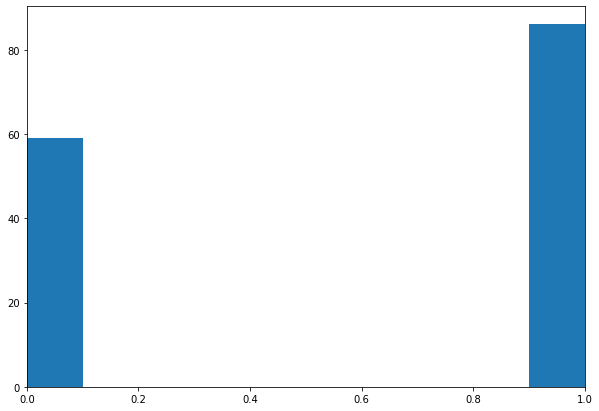

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
def analyse_transcript(trans_csv):
  x = np.array(trans_csv["importance"])

# Creating histogram
  fig, ax = plt.subplots(figsize =(10, 7))
  ax.hist(x)

  # Show plot
  plt.xlim(0,1)
  plt.show()


def display_transcript(pfc):
  if pfc >=0.2:
    return shortened_transcript["transcript"]
  else:
    return " "
analyse_transcript(pd.read_csv("/content/drive/MyDrive/Short Talks BERT/train data csv/khan_academy_01.csv"))


## **BERT Encoder Usage-2**

In [ ]:
!pip install bert-for-tf2
!pip install tensorflow==2.0
!pip install tensorflow_hub
!pip install sentencepiece

     |████████████████████████████████| 41 kB 131 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=177495aad2121fdb0412f8bd02f531fb1e22759822b6f346a786cee8136d1cff
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=1084b9b06b4f8b172ede818052d59ec09db6c9fce2342b8c4031a11edd6d6931
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7912 sha256=80a5b11a1d3383a660aa7e7470db8b0793edb5349a249627819f41a4197954e2
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
Successfully built bert-for-tf2 params-flow py-params
     |████████████████████████████████| 86.3 MB 11 kB/s 
     |███████████████████████████

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
import bert
import os
FullTokenizer = bert.bert_tokenization.FullTokenizer
from tensorflow.keras.models import Model       # Keras is the new high level API for TensorFlow
import math

In [ ]:
def make_bert_encoder():
  max_seq_length = 128  # Your choice here.
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="segment_ids")
  bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                              trainable=True)
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

  model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])
  return model
  
def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [ ]:
model_bert_encoder = make_bert_encoder()

model_bert_encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_3 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
max_seq_length = 128  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                              trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

s = "This is a nice sentence."
stokens = tokenizer.tokenize(s)
stokens = ["[CLS]"] + stokens + ["[SEP]"]

input_ids = get_ids(stokens, tokenizer, max_seq_length)
input_masks = get_masks(stokens, max_seq_length)
input_segments = get_segments(stokens, max_seq_length)
print(stokens)
print(input_ids)
print(input_masks)
print(input_segments)
pool_embs, all_embs = model.predict([[input_ids],[input_masks],[input_segments]])

['[CLS]', 'this', 'is', 'a', 'nice', 'sentence', '.', '[SEP]']
[101, 2023, 2003, 1037, 3835, 6251, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

ValueError: ignored

# **NEVER MIND THE STUFF BELOW**

In [ ]:
#JUST RUN THIS CELL

import copy
import nltk
import numpy as np
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('wordnet')
nltk.download('stopwords')

def chunk(sourceFile, wordsPerLine = None, endLineAt = None ):
  fi = open(sourceFile,"r+")
  text = fi.read()
  text = text.replace("\n","")

  

  if wordsPerLine != None :
   text = text.split()
   for words in range(1,len(text)+1):
      if words%3 == 0:
        text[words-1] = text[words-1] + "\n" 
   fi.seek(0)
   fi.write(" ".join(text))
  if endLineAt != None :
    
    for words in endLineAt :
      text = text.split(words)
      text = "\n".join(text)
      

    fi.seek(0)
    fi.write(text)
  
  fi.close()
  return

def getKey(D,val): 
    for key, value in D.items(): 
         if val == value: 
             return key 
    return -1
    
def completeFiltering(singleStringTxt, multiLineTxt, limitOnFreq, limitOnDataW = 10000):
  wholeText = singleStringTxt
  cleansed = wholeText.split()[:limitOnDataW]
  table = str.maketrans("","",string.punctuation)
  cleansed = [w.translate(table) for w in cleansed]
  patched = " ".join(cleansed)
  cleansed = patched.split()
  cleansed = [words for words in cleansed if not words.lower() in stopwords.words()]
  
  cleansedTxt = " ".join(cleansed)

  wholeText = [cleansedTxt]
  lineWiseText = multiLineTxt

  # list of text documents
  # create the transform
  vectorizer1 = CountVectorizer()
  vectorizer2 = CountVectorizer()
  # tokenize and build vocab
  vectorizer1.fit(wholeText)
  vectorizer2.fit(lineWiseText)

  # summarize
  wToInd1 = vectorizer1.vocabulary_
  wToInd2 = vectorizer2.vocabulary_
  # encode document
  vector1 = vectorizer1.transform(wholeText)
  vector2 = vectorizer2.transform(lineWiseText)
  # summarize encoded vector
  v1 = vector1.toarray()
  v2 = vector2.toarray()
  
  
  finalCount = np.sum(v1,axis = 0,keepdims = False)
  
  countDict1 = dict()
  
  countDict2 = dict()
  priorities2 = dict()
  for ind in range(len(finalCount)):
    if finalCount[ind] >=limitOnFreq :
      countDict1[getKey(wToInd1,ind)] = finalCount[ind]
  
  for lines in range(v2.shape[0]):
    countDict = dict()
    for ind in range(v2.shape[1]):
      if v2[lines][ind] >=limitOnFreq :
        countDict[getKey(wToInd2,ind)] = v2[lines][ind]
    
    priorities = sorted(countDict,key=countDict.get,reverse=True)
    
    countDict2[str(lines+1)] = countDict
    priorities2[str(lines+1)] = priorities

  contentWords = superImportant("Apple Inc")
  countDict1, misMatch = changePriorities(countDict1, contentWords)
  print("These many got mismatched : ", misMatch)
  
  priorities1 = sorted(countDict1,key=countDict1.get,reverse=True)
  
  
  
  
  return priorities1, priorities2, countDict1, countDict2

def fuzzyWayCondense(fileSource, priorities1, priorities2, prioritiesMap1, prioritiesMap2, limitOnLines = 3, limitOnDataL = 100, method = "Frequency", printLineScores = False):
  
  if method == "Frequency":
    priorities = priorities1
    prioritiesMap = prioritiesMap1
  elif method == "TF-IDF":
    priorities = priorities1
    prioritiesMap = prioritiesMap1
    prioritiesMapext = prioritiesMap2
    includeTFIDF = np.zeros((limitOnDataL,len(priorities)))

  fi = open(fileSource,"r")
  include = np.zeros((limitOnDataL,len(priorities)))
  
  wholeLines = fi.readlines()[:limitOnDataL]
  maintain = dict()
  
  for lines in range(1,limitOnDataL +1):
    maintain[str(lines)] = []
  
  fi.close()
  
  for words in priorities:
    options = process.extract(words,wholeLines,limit = limitOnDataL)
    for line,score in options:
      
      if (words in line.split()) and method == "Frequency":
        maintain[str(wholeLines.index(line)+1)].append(words)
        include[wholeLines.index(line)][priorities.index(words)] = score*prioritiesMap[words]
      elif ( words in line.split() ) and method == "TF-IDF":
        maintain[str(wholeLines.index(line)+1)].append(words)
        includeTFIDF[wholeLines.index(line)][priorities.index(words)] = prioritiesMapext[str(wholeLines.index(line)+1)][words]*prioritiesMap[words]
  
  if method == "TF-IDF":
    
    includeTFIDF = list(np.sum(includeTFIDF,axis=0))
    
    for words in priorities:
      options = process.extract(words,wholeLines,limit = limitOnDataL)
      for line,score in options:
      
        if (words in line.split()) :
          
          include[wholeLines.index(line)][priorities.index(words)] = score*includeTFIDF[priorities.index(words)]

  for lines in range(1,limitOnDataL +1):
     maintain[str(lines)] = set(maintain[str(lines)] )

  include = list(np.sum(include,axis =1))
  includeTemp = np.array(copy.deepcopy(include))
  
  if printLineScores == True :
    print("\nThe Scores of the Sentences from 1 to", limitOnDataL," are as follows \n", include)
    print("\nThe Key Words Per Line for all the lines are : \n", maintain)
 
  
  
  condensedLines = []
  condensedLinesIndices = []
  if limitOnLines != "NormSTDPick" :
    includeTemp = (np.sort(includeTemp))[::-1]
    for i in range(limitOnLines) :
      condensedLines.append(wholeLines[include.index(includeTemp[i])])
      condensedLinesIndices.append(include.index(includeTemp[i]) + 1)
      include[include.index(includeTemp[i])] = -1
  else :
    includeTemp = np.array([(value >= np.percentile(includeTemp, 90))for value in includeTemp]).astype(int)
    includeTemp = np.reshape(np.argwhere(includeTemp), (-1,)) + 1
    condensedLines = [wholeLines[i-1] for i in includeTemp]
    condensedLinesIndices = includeTemp

  condensedText = " ".join(condensedLines)

  return condensedText, condensedLines, condensedLinesIndices

         
        



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import json
T1path = "/content/drive/My Drive/AppleTranscript1.txt" #"/content/drive/My Drive/transcript1"
T2path = "/content/drive/My Drive/AppleTranscript2.txt" #"/content/drive/My Drive/transcript2"
T3path = "/content/drive/My Drive/AppleTranscript3.txt" #"/content/drive/My Drive/transcript3"
T4path = "/content/drive/My Drive/AppleTranscript4.txt" #"/content/drive/My Drive/transcript4"
Tpath = "/content/drive/My Drive/entireAppleTranscript.txt" #"/content/drive/My Drive/entireTranscript.txt"

transcript = "" 
tpt1 = open(T1path,"r")
T1 = tpt1.read()
T1dict = eval(T1)
tpt1.close()

tpt2 = open(T2path,"r")
T2 = tpt2.read()
T2dict = eval(T2)
tpt2.close()

tpt3 = open(T3path,"r")
T3 = tpt3.read()
T3dict = eval(T3)
#T3dict = json.loads(T3dict.decode("utf-8"))
tpt3.close()

tpt4 = open(T4path,"r")
T4 = tpt4.read()
T4dict = eval(T4)
#T4dict = json.loads(T4dict.decode("utf-8"))
tpt4.close()

transcript += T1dict["response"]["transcript"]
transcript += T2dict["response"]["transcript"]
transcript += T3dict["response"]["transcript"]
transcript += T4dict["response"]["transcript"]

tpt = open(Tpath,"w")
tpt.write(transcript)
tpt.close()

#tpt  = open(Tpath,"r")
Tdicts = [T1dict,T2dict,T3dict,T4dict]
#print(tpt.read())

In [ ]:
#RUN THIS CELL WITH SPECIFIED PATH TO LOAD ALL THE TEXT FILE AS STRING INTO "wholeText" AND TEXT FILE AS LINES INTO "lineWiseText"

#path = "/content/drive/My Drive/TedTranscript.txt" #Path of the file from the drive
path = Tpath # "/content/drive/My Drive/entireTranscript.txt"

chunk(path,endLineAt=[".","?"])               

fi = open(path,"r")
wholeText = fi.read()
fi.seek(0)
totalWords = len((fi.read()).split())
fi.seek(0)
totalLines = len(fi.readlines())
fi.seek(0)
lineWiseText = fi.readlines()
fi.close()

print("Total Lines present in the Source File is : ", totalLines)
print("Total Words present in the source File is : ", totalWords)


Total Lines present in the Source File is :  289
Total Words present in the source File is :  6076


In [ ]:
# "completeFiltering" func takes "wholeText", "lineWiseText", "limitOnFreq" (let this be unchanged), "limitOnDataW" (this equals the "totalWords" in above cell)
# "completeFiltering" func returns priorities1,2 and countDict1,2 which are used more for internal purposes so I'm hiding these outputs
priorities1, priorities2, countDict1, countDict2 = completeFiltering(wholeText, lineWiseText,limitOnFreq = 1, limitOnDataW=totalWords)

#print("\nTop Prior Words of 10K Words data : ", priorities1)
#print("\nTop Prior Words of every Line data : ", priorities2)

# "fuzzyWayCondense" func takes "path", "priorities1,2", "countDict1,2", "limitOnLines" (this is can be anything <= "totalLines"), "limitonDataL"(this equals the "totalLines" in above cell), "method" (let it be unchanged), "printLineScores"(let it be False setting it to True just prints scores which are of no use to u)
# "fuzzyWayCondense" func returns "condensedText"(optional use to u), "condensedLines"(optional use to u just gives list of line strings) ,"condensedLinesIndices1(u might need this)"
condensedText, condensedLines, condensedLinesIndices1 = fuzzyWayCondense(path,priorities1, priorities2,countDict1, countDict2, limitOnLines="NormSTDPick", limitOnDataL = totalLines, method = "TF-IDF", printLineScores=False)
print("\nThis is the TF-IDF Way : \n")
print("\nThe Original Lines which made thorugh the filtering process  are the line numbers : \n", condensedLinesIndices1)
#print("\nOverall the condensed Text : \n", condensedText)

# "fuzzyWayCondense" func takes "path", "priorities1,2", "countDict1,2", "limitOnLines" (this is can be anything <= "totalLines"), "limitonDataL"(this equals the "totalLines" in above cell), "method" (let it be unchanged), "printLineScores"(let it be False setting it to True just prints scores which are of no use to u)
# "fuzzyWayCondense" func returns "condensedText"(optional use to u), "condensedLines"(optional use to u just gives list of line strings) ,"condensedLinesIndices2(u might need this)"
#condensedText, condensedLines, condensedLinesIndices2 = fuzzyWayCondense(path,priorities1, priorities2,countDict1, countDict2, limitOnLines="NormSTDPick", limitOnDataL = totalLines, method = "Frequency", printLineScores=False)
#print("\nThis is the Frequency Way : \n")
#print("\nThe Original Lines which made thorugh the filtering process  are the line numbers : \n", condensedLinesIndices2)
#print("\nOverall the condensed Text : \n", condensedText)

# "finalSet" gives union of results of both methods
#finalSet =  set(condensedLinesIndices1).union(set(condensedLinesIndices2))
finalSet =  set(condensedLinesIndices1)
print("\nConsider these lines as Important : ", finalSet )
print("\nPercentage of Condensation of initial Text is : {:.4f}%".format(((totalLines - len(finalSet))/totalLines)*100))

/usr/local/lib/python3.6/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.6/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


These many got mismatched :  570

This is the TF-IDF Way : 


The Original Lines which made thorugh the filtering process  are the line numbers : 
 [ 40  43  46  52  56  62  67  89  90  99 146 150 152 159 160 166 184 185
 186 189 194 196 198 199 211 215 219 221 228]

Consider these lines as Important :  {146, 150, 152, 159, 160, 166, 40, 43, 46, 52, 184, 185, 186, 56, 189, 62, 194, 67, 196, 198, 199, 211, 215, 89, 90, 219, 221, 99, 228}

Percentage of Condensation of initial Text is : 89.9654%


In [ ]:

Jsonpath = "/content/drive/My Drive/entireAppleJason.txt" #"/content/drive/My Drive/entireJasonObj.txt"

correction = 0
for transcripts in range(4):
    for times in Tdicts[transcripts]["response"]["words"]:

      times["start"] = times["start"] + correction
      times["end"] = times["end"] + correction
      mark = times["end"]
      
    correction =   mark

jsonObjs = {"response" : dict()}
jsonObjs["response"]["words"] = T1dict["response"]["words"] + T2dict["response"]["words"] + T3dict["response"]["words"] + T4dict["response"]["words"]
jsonObjs = str(jsonObjs)
json = open(Jsonpath,"w")
json.write(jsonObjs)
json.close()

In [ ]:

pathr = Jsonpath #"/content/drive/My Drive/tedxtJasonObject" # PATH TO THE TEXT FILE CONTAINING JASON OBJECT (DICTIONARY OF REQUEST ID, RESPONSE, TIMESTAMPS OF WORDS ....)
fi = open(pathr,"r")
fullDataDict = eval(fi.read())
def convert(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds) 

wholeWords = wholeText.split()
wholeLines = lineWiseText
prevWordsCount = dict()
wds = 0
for sen in wholeLines:
     prevWordsCount[str(wholeLines.index(sen)+1)] = wds
     wds += len(sen.split())


In [ ]:

timeStamps = dict()

for line in finalSet:
     
     try:
      startInd = prevWordsCount[str(line)]
      endInd = prevWordsCount[str(line+1)] -1
     # USE "convert" if u need the output time stamps to be in HH:MM:SS if not remove "convert"
      timeRange = (fullDataDict["response"]["words"][startInd]["start"], fullDataDict["response"]["words"][endInd]["end"])
      timeStamps[int(line)] = timeRange
      count =1
     except :
      print("")

c = 0
Stamps = []
for line in sorted(timeStamps):
  c+=1
  Stamps.append(timeStamps[line])
print(Stamps)

[(385.8, 414.6), (440.6, 483.5), (501.4, 532.1), (561.0, 601.3), (634.0999999999999, 661.3), (695.0, 729.8), (742.3, 747.0), (873.9, 902.5), (902.5, 913.6999999999999), (976.8, 979.9), (1381.1999999999998, 1397.1), (1412.5, 1423.6999999999998), (1431.6999999999998, 1448.8), (1489.1999999999998, 1523.0), (1523.0, 1562.0), (1607.3, 1647.6), (1795.8, 1812.3999999999999), (1812.3999999999999, 1817.5), (1817.5, 1834.5), (1873.8999999999999, 1891.1), (1930.5, 1962.3), (1968.8999999999999, 1973.6999999999998), (1978.1999999999998, 1983.6999999999998), (1983.6999999999998, 2003.8), (2092.1, 2092.9), (2133.8, 2151.2), (2174.6, 2197.6), (2202.2, 2205.5), (2263.4, 2282.4)]
